<h1>Preprocessing and Inference of Sentinel 2 downloaded images</h1>

Prerequisites:
- Google Drive account with the downloaded images folder (Sufficient space to save the preprocessed and predicted images - same as input size)


**Input:** A drive Downloaded Sentinel2 GeoTiff images , 11 Bands, 300x300 pixels

**Output:** Preprocessed GeoTiff images (300x300px):
- Preprocessed: 15 bands
- Predicted masks: 1 band 3 classes (0: 0 Other,1: 250 Non-Residential,2: 255 Residential)

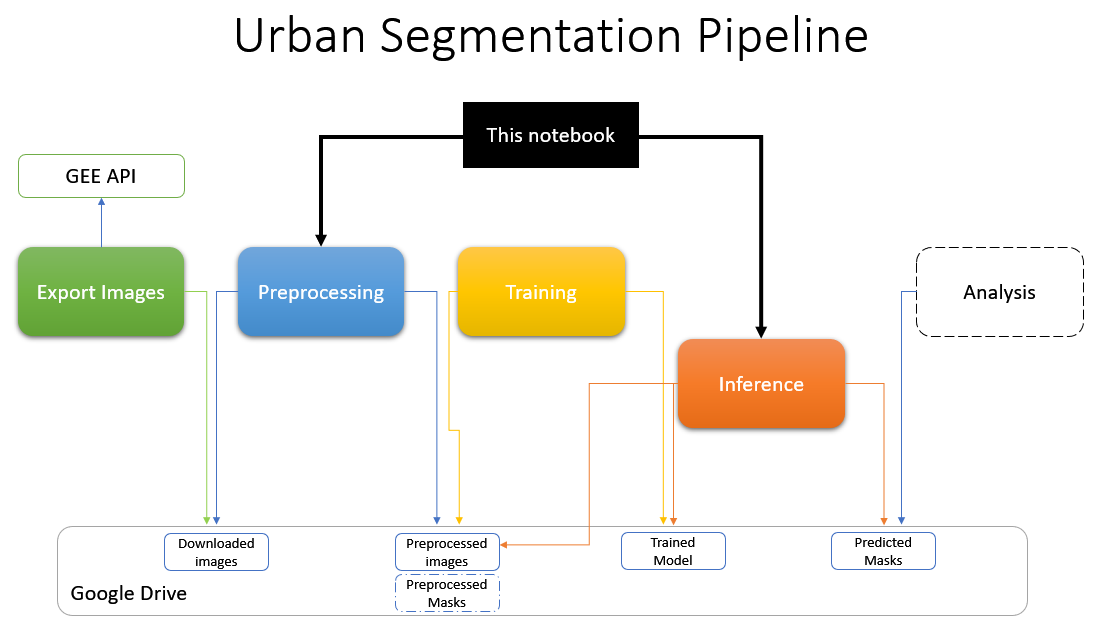

## Running instructions



1.   Connect to the NB (make sure GPU is selected as runtime: "Runtime"-->"Change Runtime Type")
2.   Upload the ssh keys file on "Files" left side panel
3.   Update the downloaded images **input path** in "EXPORT_DIR" in the next cell
4.   Change VERBOSE to True if you want to plot the images and predictions samples (takes a little longer to run)
5.   Run the notebook to predict the masks



In [8]:
#TODO >>>>>>>>>> CHANGE TO THE DOWNLOADED IMAGES DIRECTORY (INPUT)
EXPORT_DIR='/content/drive/MyDrive/gee_export_Jul_14_2022_1601test'
#TODO Change to "True" to see predicted masks (takes a bit longer to run)
VERBOSE=True

## Setup

Upload the Git credentials files on the left files panel (if using a secured)Git repo

Alternatively you can download the [Urban Segmentation Git](https://github.com/lleviraz/urban_segmentation) Repo as ZIP file, then upload and extract here 

In [9]:
import os
if(not os.path.exists('urban_segmentation')):
  if(os.path.exists('/root/.ssh')):
    !mv -f /root/.ssh /root/.ssh_old
  !unzip gitssh.zip && mv .ssh /root/ && chmod -R 400 /root/.ssh && ls /root/.ssh
  !git clone git@github.com:lleviraz/urban_segmentation.git

Note: if you are using local directories, you can comment out the next cell and assume all paths are locally accessible

In [10]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!pip install rasterio fastai -q torch torchmetrics

In [12]:
import sys
import sys
import glob
import torch
import numpy as np
import pprint as pp
import pandas as pd
from pprint import pprint
from pathlib import Path
from tqdm.notebook import tqdm

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Source folder with the downloaded images (CHANGE INPUT AND OUTPUT DIRECTORIES)

A new target folder will be created with the same location and name and suffix **"_prep"**
All the preprocessed images will be placed there

In [14]:
#Current working directory
#TODO >>>>>>>>>> IF NEEDED CHANGE TO THE CURRENT WORKING DIRECTORY OF THE NOTEBOOK
WORK_DIR = 'urban_segmentation/'
NB_DIR = WORK_DIR + 'notebooks/'

PREPROC_DIR = EXPORT_DIR + '_prepproc/'
META_DIR = EXPORT_DIR + '_metadata/'

S2_DIR = EXPORT_DIR
s2_path = Path(S2_DIR)

# This directory is the parent of the "libs" directory which is imported below
sys.path.append(NB_DIR)

#Our implementation (can be called after setting env directories)
from libs.common import *
from libs.bands import *
from libs.training import *
from libs.inference import *

path1 = Path(EXPORT_DIR)
three_files = [f for f in path1.iterdir()][:3]
pprint(three_files)
print('Number of input images:',len(glob.glob(S2_DIR + '/*.tif')))

[PosixPath('/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/s2_img_1.tif'),
 PosixPath('/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/s2_img_2.tif'),
 PosixPath('/content/drive/MyDrive/gee_export_Jul_14_2022_1601test/s2_img_3.tif')]
Number of input images: 49


## Part 1 - Preprocessing 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


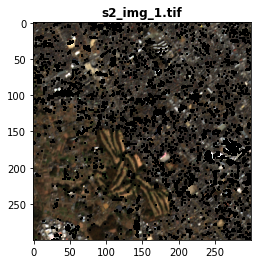

s2_img_1.tif Metadata: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 300, 'height': 300, 'count': 11, 'crs': CRS.from_epsg(3857), 'transform': Affine(12.379094069612522, 0.0, 15533706.569938207,
       0.0, -12.433727354093765, 4300933.988254617)}
s2_img_1.tif Transform:
 | 12.38, 0.00, 15533706.57|
| 0.00,-12.43, 4300933.99|
| 0.00, 0.00, 1.00|


In [15]:
CMAP='brg_r'
SAMPLE_IMAGE = three_files[0]
if(VERBOSE):
  s2_sample = display_image(SAMPLE_IMAGE,title=SAMPLE_IMAGE.name)
  print_image_metadata(s2_sample,SAMPLE_IMAGE.name)

In [16]:
NUM_BANDS = 15

bands_dictionary = {
    1:'B1_Blue',
    2:'B2_Green',
    3:'B3_Red',
    4:'B4_Red_Edge_1',
    5:'B5_Red_Edge_2',
    6:'B6_Red_Edge_3',
    7:'B7_NIR',
    8:'B8_Red_Edge_4',
    9:'B9_Water_vapor',
    10:'B10_SWIR_1',
    11:'B11_SWIR_2',
    12:'B12_NDVI', #added in this NB
    13:'B13_NDTI', #added in this NB
    14:'B14_NDVIre', #added in this NB
    15:'B15_MNDWI' #added in this NB
}

## In case the source images names have spaces you can use this to replace it with "_"

In [17]:
#UNCOMMENT to rename
# rename_images(S2_DIR)

In [18]:
#UNCOMMENT if you want to regenerate all images
# !rm -rf {PREPROC_DIR}

## Resizing to 300x300 + adding 4 new bands to the target images

The target folder will be used in the Inference notebook as input

In [19]:
batch_resize(S2_DIR,PREPROC_DIR,n_bands=NUM_BANDS)

Source dir: /content/drive/MyDrive/gee_export_Jul_14_2022_1601test
Target dir: /content/drive/MyDrive/gee_export_Jul_14_2022_1601test_prepproc/
Creating  /content/drive/MyDrive/gee_export_Jul_14_2022_1601test_prepproc/
49 images to resize + additional 4 band to  (15, 300, 300)


  0%|          | 0/49 [00:00<?, ?it/s]

## Calculating new images per band statistics

In [20]:
stats_mean_df = pd.DataFrame(columns=range(1,NUM_BANDS))
stats_std_df = pd.DataFrame(columns=range(1,NUM_BANDS))

s2_images = glob.glob(PREPROC_DIR+ '/*.tif')
for row,image in tqdm(enumerate(s2_images),total=len(s2_images)):
  with rio.open(image,'r') as im:
    for c in range(1,im.count+1):
      chn=np.array(im.read(c))
      #imputing mean and STD of  exported images with the mean and STD of the other non nans values in the channel
      if(np.isnan(chn).sum()>0):
        not_nan =(np.isnan(chn)==False)
        stats_mean_df.loc[row,c] =  chn[not_nan].mean()
        stats_std_df.loc[row,c] = chn[not_nan].std()
        # print(np.isnan(chn).sum())
      else:
        stats_mean_df.loc[row,c] = chn.mean()
        stats_std_df.loc[row,c] = chn.std()
       


  0%|          | 0/49 [00:00<?, ?it/s]

In [21]:
cp = stats_mean_df.dropna()

len(stats_mean_df),len(cp)

(49, 49)

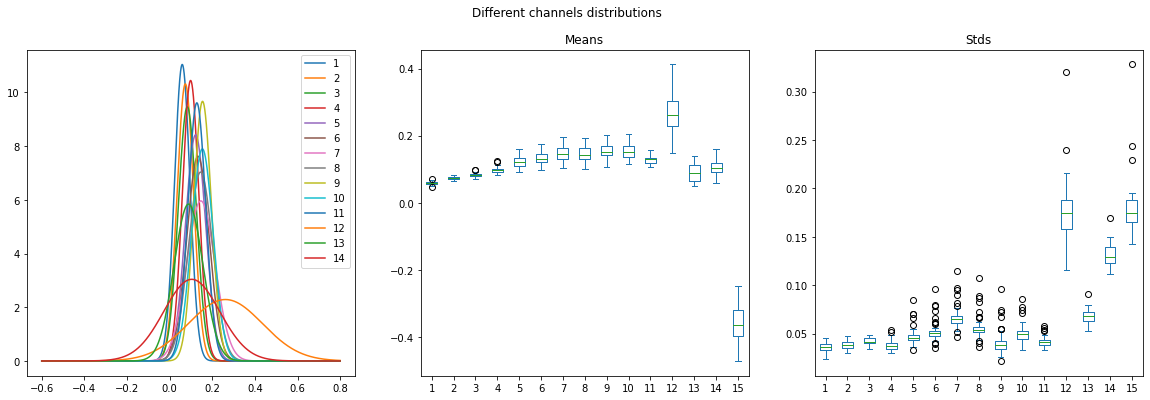

In [22]:
if(VERBOSE):
  f,axs = plt.subplots(1,3,figsize=(20,6))
  x = np.arange(-0.6, 0.8, 1e-04)
  for i in range(1,NUM_BANDS):
    #Filter some bands
    # if i in [11,12,13,14,15,16]:
    axs[0].plot(x, scipy.stats.norm.pdf(x, stats_mean_df.mean()[i], stats_std_df.mean()[i]),label=i)
      

  stats_mean_df.plot.box(ax=axs[1])
  # stats_mean_df[[12,13,14,15]].plot.box(ax=axs[1])
  axs[1].set_title('Means')
  stats_std_df.plot.box(ax=axs[2])
  # stats_std_df[[12,13,14,15]].plot.box(ax=axs[2])
  axs[2].set_title('Stds')
  axs[0].legend()
  plt.suptitle('Different channels distributions')
  plt.show()

In [23]:
#TODO put these under {PREPROC_DIR}_metadata
!mkdir -p {META_DIR}
stats_mean_df.to_csv(META_DIR + 'down_stats_mean_df.csv',header=True)
stats_std_df.to_csv(META_DIR + 'down_stats_std_df.csv',header=True)

In [24]:
# stats_mean_df = pd.read_csv('down_stats_mean_df.csv',header=0,index_col=0)
def get_global_chn_mean(band):
  '''
  Returns the global mean of a channel based on the statistics calculated in preprocessing
  Used for imputation of nan values in expoerted images (last resort...)
  '''
  return stats_mean_df[band].mean()

### Part 2 - Inference

**Predicted Classes**

Originally we have 4 classes in the input images:
- 250 for non-residential **(Red)**
- 255 for residential     **(Blue)**
- 1 for all other areas   **(Green , merged into 0)**
- 0 for no data           **(Green also)**

We turn them to a sequence 0 to 3 for the segmentation to work properly:
codes decoder dictionary (0,1,2,3)->(0,1,250,255)

After many experiments we merged the 0 and 1 classes into 0 - which is the "background" class

In [25]:
MERGE_BG_CLASSES=True
if(MERGE_BG_CLASSES):
  code2class = {0:0,1:250,2:255}
  class2code={0:0,250:1,255:2}
  class2desc={0:'Other',250:'Non Resi',255:'Resi'}
else:
  code2class = {0:0,1:1,2:250,3:255}
  class2code={0:0,1:1,250:2,255:3}
  class2desc={0:'No Data',1:'Other',250:'Non Resi',255:'Resi'}

Show 2 samples , normalized and RGB with and without augmentations

The augmented images may look the same as the original, depending on the augmentation probability (default 0.2) 


## Loading trained UNET model

Best UNet model Mean Dice score:0.83

In [26]:
n_channels = NUM_BANDS
n_classes=len(class2code)
model_unet = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=True)

In [27]:
%%time

clear_cache()

def load_pretrained():
    model_unet.load_state_dict(torch.load(FINAL_MODEL_PATH),strict=False)
    print('loaded model from:',FINAL_MODEL_PATH)
    return model_unet.to(device)
    
FINAL_MODEL_PATH=WORK_DIR +'models/final_model.pth'
final_states_dict_file = Path(FINAL_MODEL_PATH)
INFERECE_MODE=final_states_dict_file.is_file()

print('Inference mode: loading model states dict...')
model_unet = load_pretrained()


Inference mode: loading model states dict...
loaded model from: urban_segmentation/models/final_model.pth
CPU times: user 1.32 s, sys: 779 ms, total: 2.1 s
Wall time: 5.08 s


In [28]:

test2_images = load_tif_files(PREPROC_DIR,'Downloaded')
TARGET_PREDS_DIR = '/content/target_preds'
!rm -rf {TARGET_PREDS_DIR}
!mkdir -p {TARGET_PREDS_DIR}

Downloaded - 49 image files in /content/drive/MyDrive/gee_export_Jul_14_2022_1601test_prepproc/


In [29]:
%%time

test2_ds  = S2OnlyDataset(test2_images)
test2_dl = torch.utils.data.DataLoader(test2_ds, batch_size=1, shuffle=False)
print(len(test2_dl),'batches,',len(test2_ds),'images')

  0%|          | 0/49 [00:00<?, ?it/s]

49 batches, 49 images
CPU times: user 2.43 s, sys: 329 ms, total: 2.76 s
Wall time: 4.28 s


In [30]:
clear_cache()

test2_preds = predict(model_unet,test2_dl,device)

  0%|          | 0/49 [00:00<?, ?it/s]

49 49


  0%|          | 0/49 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pred masks saved to: /content/target_preds


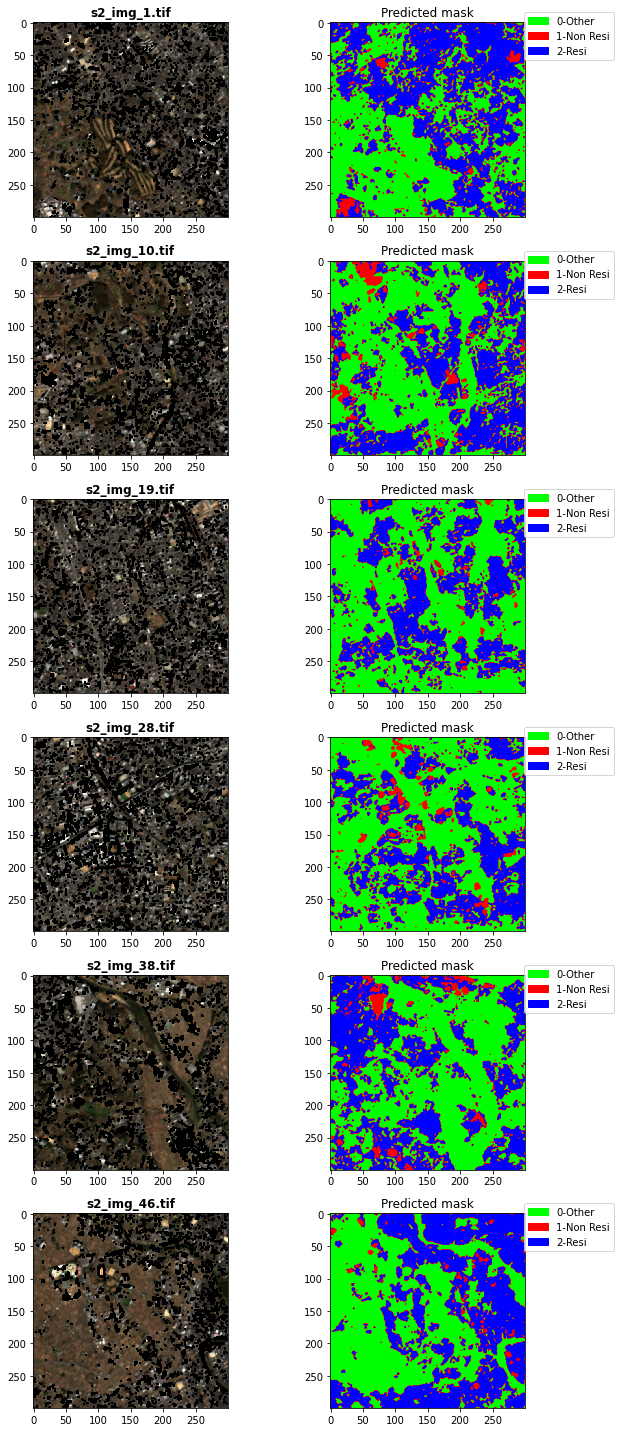

In [31]:
flat2_preds = [x for xs in test2_preds for x in xs]
print(len(test2_images),len(flat2_preds))
plot_predictions(test2_images,flat2_preds,PREPROC_DIR,
                 TARGET_PREDS_DIR,cmap=CMAP,code2class=code2class,
                 class2desc=class2desc,show_every=9,verbose=VERBOSE)

49


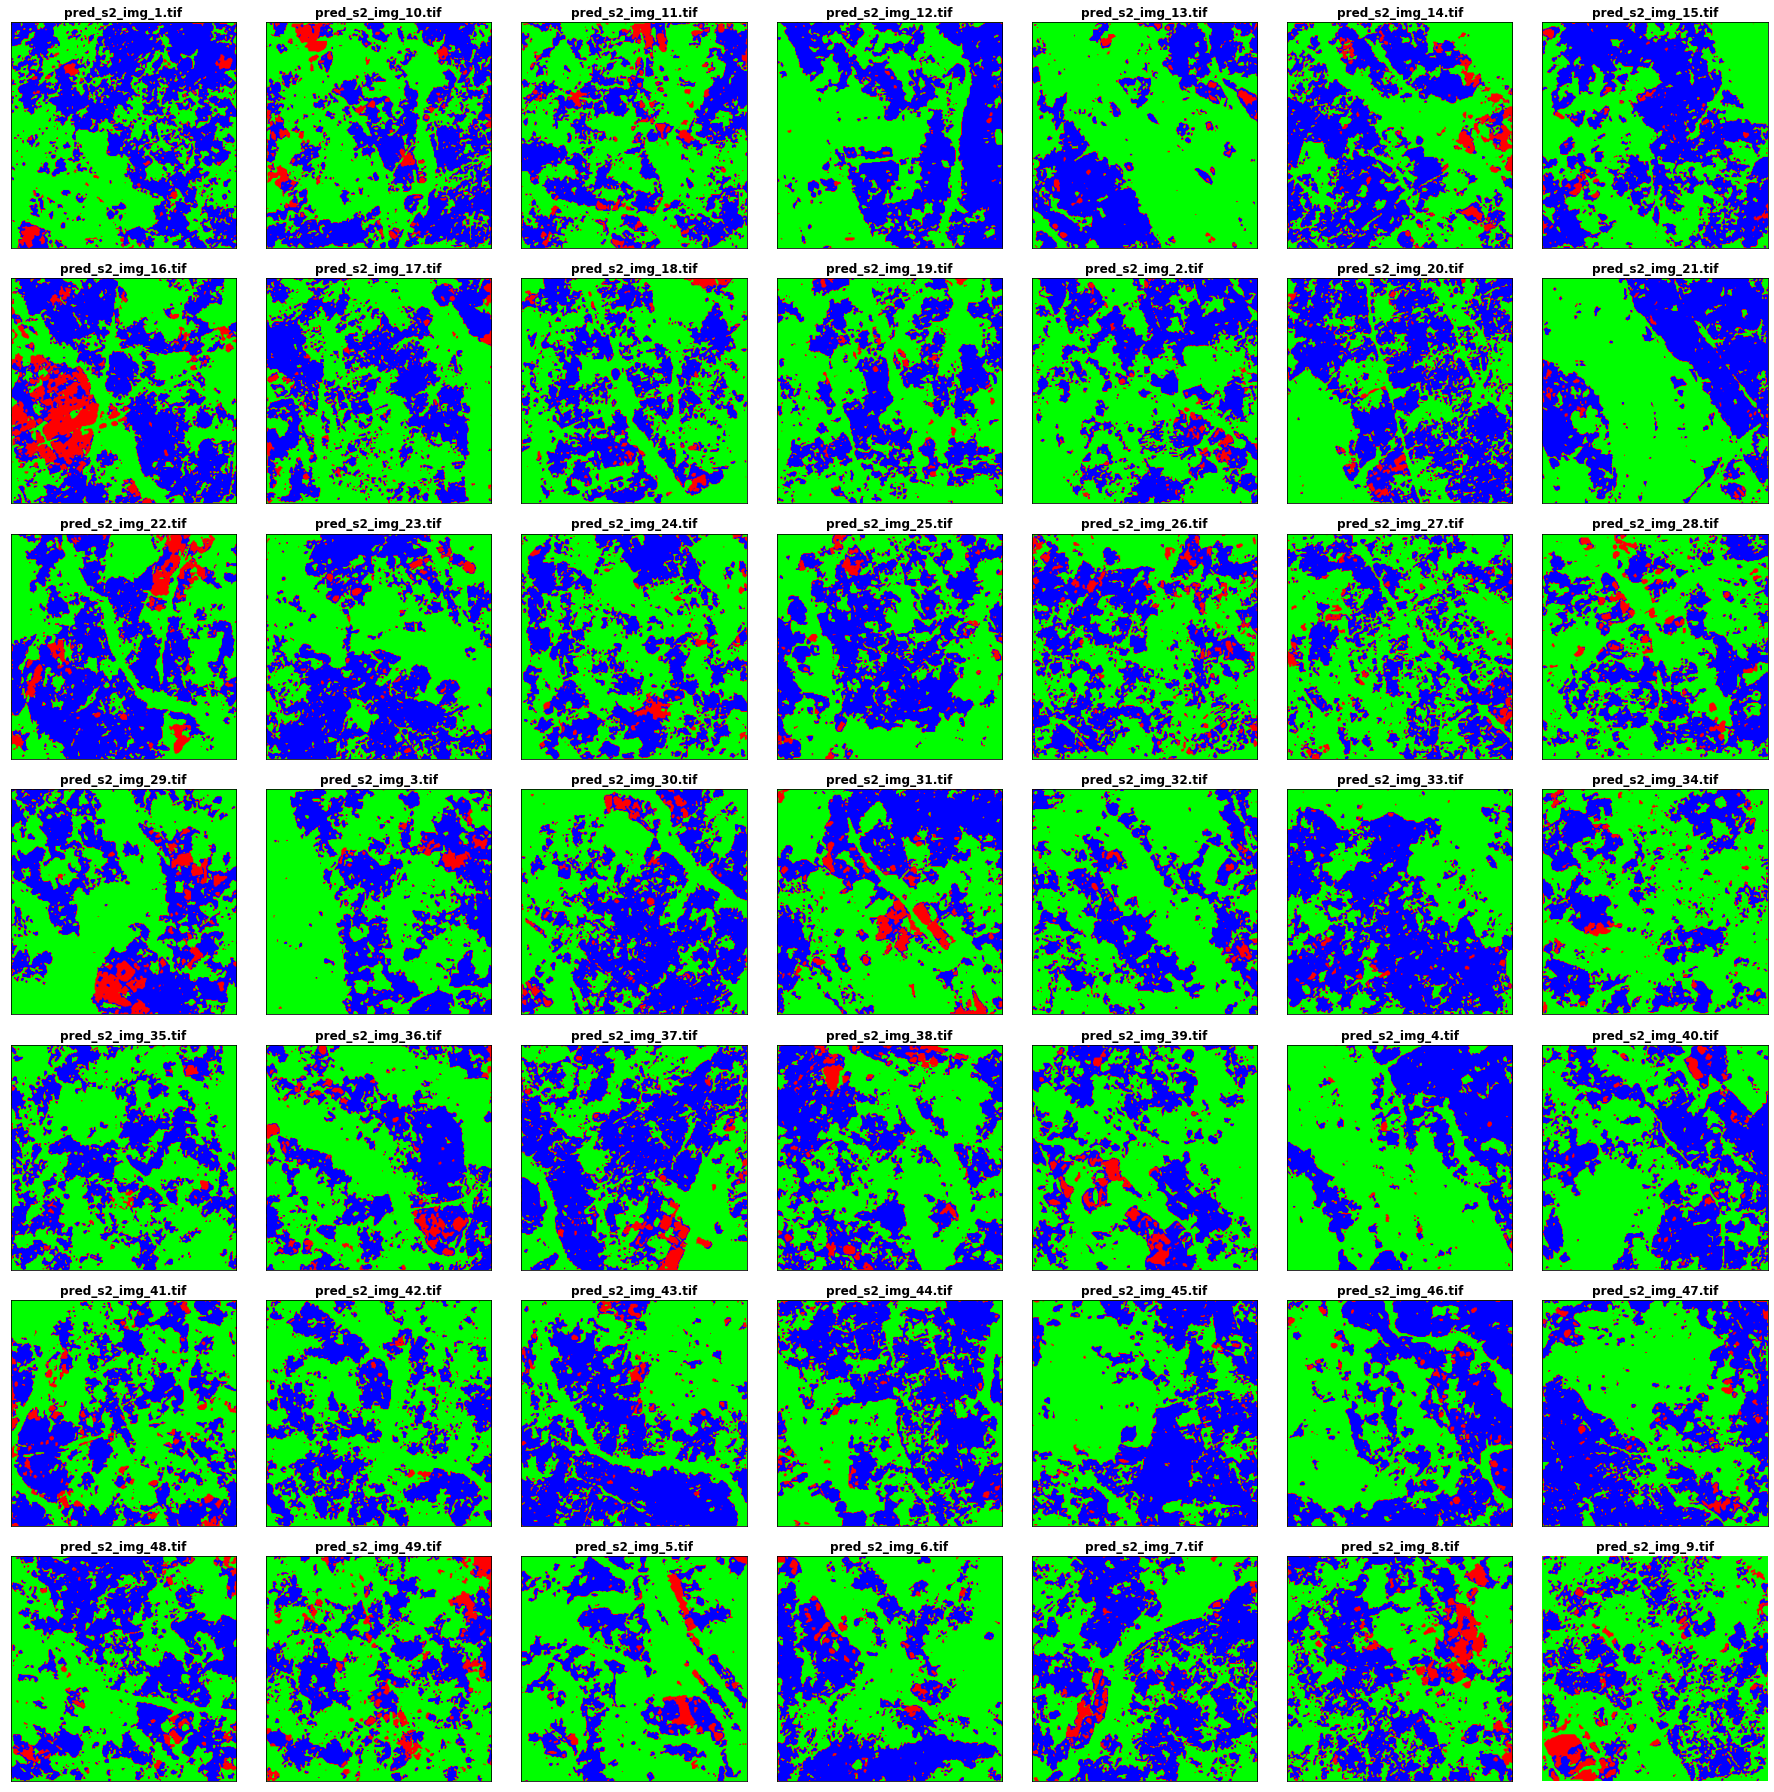

In [32]:
if(VERBOSE):
  SAITAMA = TARGET_PREDS_DIR
  sait = glob.glob(os.path.join(SAITAMA,'*.tif'))
  sait = sorted(sait)
  print(len(sait))
  f,axs = plt.subplots(7,7,figsize=(25,25))
  im_no = 0
  for i in range(7):
    for j in range(7):
      a = show_image(sait[im_no],bands=[1],cm=CMAP,title='{}'.format(parse_file_name(sait[im_no])),ax=axs[i,j])
      axs[i,j].axes.xaxis.set_visible(False)
      axs[i,j].axes.yaxis.set_visible(False)
      im_no+=1
  plt.axis("off")
  plt.tight_layout()
  plt.show()

In [33]:
#Change to True in order to backup predictions to drive
BACKUP=False
if(BACKUP):
  print('Uploading images to:',WORK_DIR)
  !cp -rf {TARGET_PREDS_DIR} WORK_DIR
  !cp -rf {PREDS_DIR} WORK_DIR
print('Predictions saved to:',TARGET_PREDS_DIR)

Predictions saved to: /content/target_preds
